# YOLO Object Detection with OpenCV
## A Practical Implementation in Google Colab

This notebook demonstrates how to implement YOLO (You Only Look Once) object detection using OpenCV and Python.


# Install any required packages if necessary

In [17]:
!pip install opencv-python==4.7.0.72 matplotlib==3.7.2 numpy==1.24.3

# Import required libraries

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Setting up YOLO Model
We need to download the YOLO model files: weights, configuration, and class names.



In [19]:
# Create directory for YOLO files
!mkdir -p yolo

# Download YOLO weights, config and class names
!wget -O yolo/yolov3.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget -O yolo/coco.names https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2025-04-26 21:31:36--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolo/yolov3.cfg’

yolo/yolov3.cfg     100%[===================>]   8.15K  --.-KB/s    in 0s      

2025-04-26 21:31:37 (52.0 MB/s) - ‘yolo/yolov3.cfg’ saved [8342/8342]

--2025-04-26 21:31:37--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘yolo/co

Download the yolov3.weights file:

1. Go to https://www.kaggle.com/datasets/shivam316/yolov3-weights
2. Download the yolov3.weights file from Kaggle
3. In Google Colab, click on the folder icon in the left sidebar to open the file browser
4. Create a folder named "yolo" (if it doesn't already exist)
5. Upload the downloaded yolov3.weights file to the "yolo" folder in Colab
6. Make sure the file path in your code is set to 'yolo/yolov3.weights'


In [20]:
# Set paths
weights_path = 'yolo/yolov3.weights'
config_path = 'yolo/yolov3.cfg'
classes_path = 'yolo/coco.names'

# Core Functions
These functions handle the main operations for object detection with YOLO:
- Loading the model and class names
- Processing images
- Drawing detection boxes


In [21]:
def load_class_names(filename):
    """Load class names from file."""
    with open(filename, "r") as f:
        return [line.strip() for line in f.readlines()]

def load_yolo_network(weights_path, config_path):
    """Load YOLO network from weights and configuration files."""
    return cv2.dnn.readNetFromDarknet(config_path, weights_path)

def get_output_layers(network):
    """Get the names of output layers."""
    layer_names = network.getLayerNames()
    return [layer_names[i - 1] for i in network.getUnconnectedOutLayers()]

def draw_bounding_box(image, class_id, confidence, x, y, x_plus_w, y_plus_h, class_names):
    """Draw bounding box around detected object."""
    label = f"{class_names[class_id]}: {confidence:.2f}"
    # Generate a random color for the box
    color = [int(c) for c in np.random.uniform(0, 255, size=(3,))]
    cv2.rectangle(image, (int(x), int(y)), (int(x_plus_w), int(y_plus_h)), color, 2)
    cv2.putText(image, label, (int(x), int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Image Processing Functions
These functions prepare and process the image for object detection.

In [22]:
def prepare_image(image, scale=0.00392, size=(416, 416)):
    """Prepare image for detection by creating a blob."""
    return cv2.dnn.blobFromImage(image, scale, size, (0, 0, 0), True, crop=False)

def process_detections(outs, width, height, conf_threshold):
    """Process network outputs to extract detections."""
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    return class_ids, confidences, boxes

def apply_non_max_suppression(boxes, confidences, conf_threshold, nms_threshold):
    """Apply non-maximum suppression to remove redundant boxes."""
    return cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

def draw_detections(image, indices, boxes, class_ids, confidences, class_names):
    """Draw all detected objects on the image."""
    if len(indices) > 0:
        for i in indices.flatten():
            box = boxes[i]
            x, y, w, h = box[0], box[1], box[2], box[3]
            draw_bounding_box(
                image, class_ids[i], confidences[i],
                round(x), round(y), round(x+w), round(y+h), class_names
            )
    return image

# Object Detection Function
The main function that coordinates the entire detection process.

In [23]:
def detect_objects(image, weights_path, config_path, classes_path, conf_threshold=0.5, nms_threshold=0.4):
    """Main function to detect objects in an image."""
    # Load class names and network
    class_names = load_class_names(classes_path)
    net = load_yolo_network(weights_path, config_path)

    # Prepare image
    height, width = image.shape[:2]
    blob = prepare_image(image)

    # Perform detection
    net.setInput(blob)
    outs = net.forward(get_output_layers(net))

    # Process detections
    class_ids, confidences, boxes = process_detections(outs, width, height, conf_threshold)

    # Apply non-max suppression
    indices = apply_non_max_suppression(boxes, confidences, conf_threshold, nms_threshold)

    # Draw bounding boxes
    image = draw_detections(image, indices, boxes, class_ids, confidences, class_names)

    # Count detections by class
    detection_counts = {}
    if len(indices) > 0:
        for i in indices.flatten():
            class_name = class_names[class_ids[i]]
            detection_counts[class_name] = detection_counts.get(class_name, 0) + 1

    return image, detection_counts

def display_image(image, figsize=(12, 8)):
    """Display the image with detections."""
    # Convert BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test
Use a sample image for object detection

In [30]:
# !mkdir -p sample_images
# !wget -O sample_images/dog.jpg https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg

# image = cv2.imread('sample_images/dog.jpg')
# image = cv2.imread('sample_images/sample-1.jpg')
# image = cv2.imread('sample_images/sample-2.jpg')
# image = cv2.imread('sample_images/sample-3.jpg')
image = cv2.imread('sample_images/sample-4.jpg')

# Object Detection Results
Running the detection on the sample image and displaying the results.

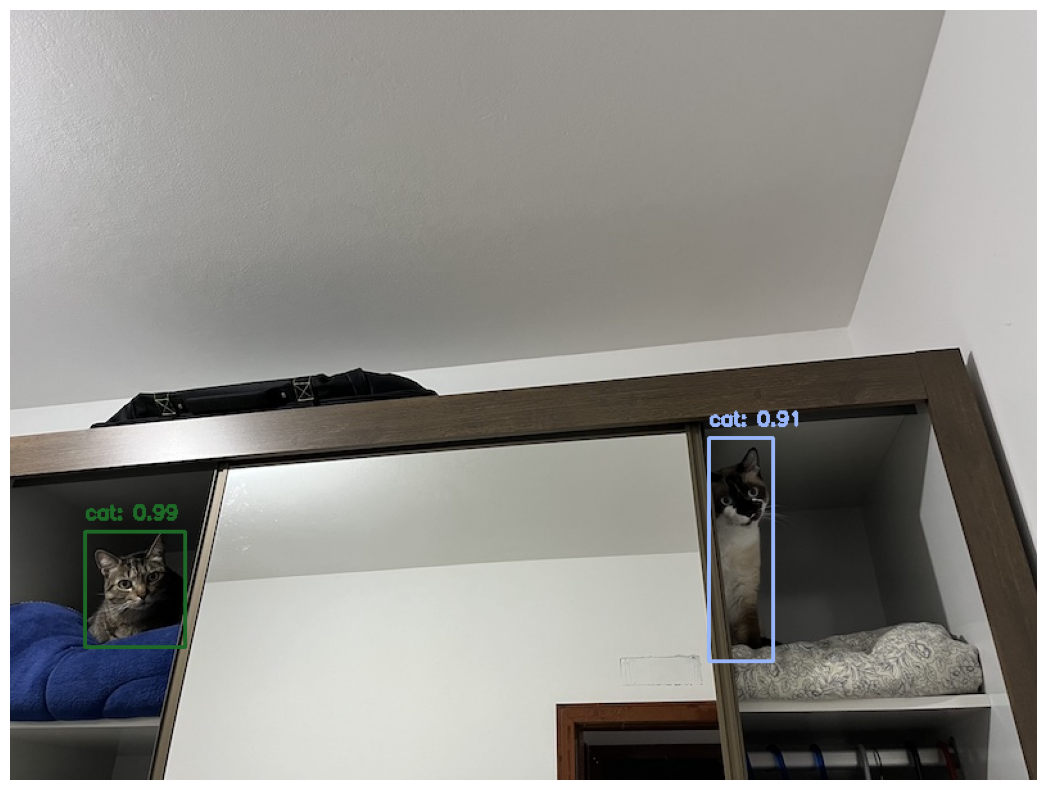

Objects detected:
- cat: 2


In [31]:
# Detect objects
result_image, detection_counts = detect_objects(
    image, weights_path, config_path, classes_path,
    conf_threshold=0.5, nms_threshold=0.4
)

# Display the image with detections
display_image(result_image)

# Display detection counts
print("Objects detected:")
for class_name, count in detection_counts.items():
    print(f"- {class_name}: {count}")

References

https://pjreddie.com/darknet/

https://github.com/pjreddie/darknet

